In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data
import random
from torchvision import transforms
import torchvision.models.vgg as vgg
import torch.utils.model_zoo as model_zoo
from collections import namedtuple
import torch
from PIL import Image
from torch.nn import functional as F
import os , itertools
from glob import glob
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Parameter

In [ ]:
#model params
params = {
    'batch_size':16,
    'input_size':256,
    'resize_scale':256,
    'crop_size':256,
    'fliplr':True,
    'num_epochs':100,
    'decay_epoch':50,
    'ngf':32,   #number of generator filters
    'ndf':64,   #number of discriminator filters
    'num_resnet':6, #number of resnet blocks
    'lrG':0.0002,    #learning rate for generator
    'lrD':0.0002,    #learning rate for discriminator
    'beta1':0.5 ,    #beta1 for Adam optimizer
    'beta2':0.999 ,  #beta2 for Adam optimizer
    'lambdaA':10 ,   #lambdaA for cycle loss
    'lambdaB':10,  #lambdaB for cycle loss
    'img_form':'jpg'
}

data_dir = '../../d'

In [ ]:
def to_np(x):
    return x.data.cpu().numpy()
def plot_train_result(real_image, gen_image, recon_image, epoch, save=False,  show=True, fig_size=(15, 15)):
    fig, axes = plt.subplots(2, 3, figsize=fig_size)
    imgs = [to_np(real_image[0]), to_np(gen_image[0]), to_np(recon_image[0]),
            to_np(real_image[1]), to_np(gen_image[1]), to_np(recon_image[1])]
    for ax, img in zip(axes.flatten(), imgs):
        ax.axis('off')
        #ax.set_adjustable('box-forced')
        # Scale to 0-255
        img = img.squeeze()
        img = (((img - img.min()) * 255) / (img.max() - img.min())).transpose(1, 2, 0).astype(np.uint8)
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)

    title = 'Epoch {0}'.format(epoch + 1)
    fig.text(0.5, 0.04, title, ha='center')

    # save figure
    if save:
        save_fn = 'Result_epoch_{:d}'.format(epoch+1) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()

dataLoader

In [ ]:
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images.data:
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:
                    random_id = random.randint(0, self.pool_size-1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = Variable(torch.cat(return_images, 0))
        return return_images
        
class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, subfolder='train', transform=None, resize_scale=None, crop_size=None, fliplr=False):
        super(DatasetFromFolder, self).__init__()
        self.input_path = os.path.join(image_dir, subfolder)
        self.image_filenames = [x for x in sorted(glob(self.input_path+'/*.'+params['img_form']))]
        self.image_filenames = [f.replace(self.input_path+'/', '') for f in self.image_filenames]
        print(self.image_filenames)
        self.transform = transform
        
        self.resize_scale = resize_scale
        self.crop_size = crop_size
        self.fliplr = fliplr

    def __getitem__(self, index):
        # Load Image
        img_fn = os.path.join(self.input_path, self.image_filenames[index])
        img = Image.open(img_fn).convert('RGB')

        # preprocessing
        if self.resize_scale:
            img = img.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)

        if self.crop_size:
            x = random.randint(0, self.resize_scale - self.crop_size + 1)
            y = random.randint(0, self.resize_scale - self.crop_size + 1)
            img = img.crop((x, y, x + self.crop_size, y + self.crop_size))
        if self.fliplr:
            if random.random() < 0.5:
                img = img.transpose(Image.FLIP_LEFT_RIGHT)

        if self.transform is not None:
            img = self.transform(img)

        return img

    def __len__(self):
        return len(self.image_filenames)

CycleGAN Architecture

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features*2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features*2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features//2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features//2

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

Load dataset

In [ ]:
transform = transforms.Compose([
    transforms.Resize(size=params['input_size']),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
#Subfolders - day & night
train_data_A = DatasetFromFolder(data_dir, subfolder='standard', transform=transform,
                                resize_scale=params['resize_scale'], crop_size=params['crop_size'], fliplr=params['fliplr'])
train_data_loader_A = torch.utils.data.DataLoader(dataset=train_data_A, batch_size=params['batch_size'], shuffle=True)
train_data_B = DatasetFromFolder(data_dir, subfolder='Notstandard', transform=transform,
                                resize_scale=params['resize_scale'], crop_size=params['crop_size'], fliplr=params['fliplr'])
train_data_loader_B = torch.utils.data.DataLoader(dataset=train_data_B, batch_size=params['batch_size'], shuffle=True)
 

In [ ]:
test_real_A_data = train_data_A.__getitem__(11).unsqueeze(0) 
test_real_B_data = train_data_B.__getitem__(91).unsqueeze(0)

Build model

In [ ]:
#Build Model 
#G_A - Day->Night ; G_B - Night -> Day
G_A = Generator(3,3).to(device) 
G_B = Generator(3,3).to(device)

#two Discriminators
D_A = Discriminator(3).to(device)
D_B = Discriminator(3).to(device)

G_A.apply(weights_init_normal)
G_B.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)


G_optimizer = torch.optim.Adam(itertools.chain(G_A.parameters(), G_B.parameters()), lr=params['lrG'], betas=(params['beta1'], params['beta2']))
D_A_optimizer = torch.optim.Adam(D_A.parameters(), lr=params['lrD'], betas=(params['beta1'], params['beta2']))
D_B_optimizer = torch.optim.Adam(D_B.parameters(), lr=params['lrD'], betas=(params['beta1'], params['beta2']))

Loss functions

In [ ]:
MSE_Loss = torch.nn.MSELoss().to(device)
L1_Loss = torch.nn.L1Loss().to(device)
LossOutput = namedtuple("LossOutput", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"])

# https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3
class LossNetwork(torch.nn.Module):
    def __init__(self, vgg_model):
        super(LossNetwork, self).__init__()
        self.vgg_layers = vgg_model.features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3"
        }
    
    def forward(self, x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return LossOutput(**output)

vgg_model = vgg.vgg16(pretrained=True)
if torch.cuda.is_available():
    vgg_model.to(device)
loss_network = LossNetwork(vgg_model)
loss_network.eval()
del vgg_model

def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

def compStyle(a,b):
    #http://pytorch.org/docs/master/notes/autograd.html#volatile
    styleB_loss_features = loss_network(Variable(a, volatile=True))
    gram_style = [Variable(gram_matrix(y).data, requires_grad=False) for y in styleB_loss_features]
        
    features_y = loss_network(b)
        
    style_loss = 0    
    for m in range(len(features_y)):
        gram_s = gram_style[m]
        gram_y = gram_matrix(features_y[m])
        style_loss += 1e4 * MSE_Loss(gram_y, gram_s.expand_as(gram_y))
    return style_loss

Train Model

In [ ]:
D_A_avg_losses = []
D_B_avg_losses = []
G_A_avg_losses = []
G_B_avg_losses = []
cycle_A_avg_losses = []
cycle_B_avg_losses = []
STYLE_WEIGHT = 1e4

num_pool = 50
fake_A_pool = ImagePool(num_pool)
fake_B_pool = ImagePool(num_pool)
import tqdm
step = 0
for epoch in range(params['num_epochs']):
    D_A_losses = []
    D_B_losses = []
    G_A_losses = []
    G_B_losses = []
    cycle_A_losses = []
    cycle_B_losses = []
    
    # Learing rate decay 
    if(epoch + 1) > params['decay_epoch']:
        D_A_optimizer.param_groups[0]['lr'] -= params['lrD'] / (params['num_epochs'] - params['decay_epoch'])
        D_B_optimizer.param_groups[0]['lr'] -= params['lrD'] / (params['num_epochs'] - params['decay_epoch'])
        G_optimizer.param_groups[0]['lr'] -= params['lrG'] / (params['num_epochs'] - params['decay_epoch'])
        

    iteratorA=tqdm.notebook.tqdm(train_data_loader_A)
    iteratorB=tqdm.notebook.tqdm(train_data_loader_B)
    for i, (real_A, real_B) in enumerate(zip(iteratorA, iteratorB)):
        
        # input image data
        real_A = real_A.to(device)
        real_B = real_B.to(device)
        
        # -------------------------- train generator G --------------------------
        # A --> B
        fake_B = G_A(real_A)
        a_idt = G_A(real_A)
        
        D_B_fake_decision = D_B(fake_B)
        G_A_loss = MSE_Loss(D_B_fake_decision, Variable(torch.ones(D_B_fake_decision.size()).to(device)))
        
        # forward cycle loss
        recon_A = G_B(fake_B)
        cycle_A_loss = L1_Loss(recon_A, real_A) * params['lambdaA']
        
        #idtA_loss = L1_Loss(a_idt,real_A) * 10*0.5 
        
        styleA_loss = compStyle(real_A,a_idt) 
        
    
        #G_B_loss = G_B_loss + (style_loss)/2
       
        #ends here
        
        # B --> A
        fake_A = G_B(real_B)
        b_idt = G_B(real_B)
        
        D_A_fake_decision = D_A(fake_A)
        G_B_loss = MSE_Loss(D_A_fake_decision, Variable(torch.ones(D_A_fake_decision.size()).to(device)))
        
        # backward cycle loss
        recon_B = G_A(fake_A)
        cycle_B_loss = L1_Loss(recon_B, real_B) * params['lambdaB']
        
        #idtB_loss = L1_Loss(b_idt,real_B) * 10*0.5 
    
        styleB_loss = compStyle(real_B,b_idt) 

        style_loss = (styleB_loss + styleA_loss)
        
        # Back propagation
        G_loss = G_A_loss + G_B_loss + cycle_A_loss + cycle_B_loss 
        
        G_loss = G_loss+style_loss * 2.5
        
        
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()
    
        
        # -------------------------- train discriminator D_A --------------------------
        D_A_real_decision = D_A(real_A)
        D_A_real_loss = MSE_Loss(D_A_real_decision, Variable(torch.ones(D_A_real_decision.size()).to(device)))
        
        fake_A = fake_A_pool.query(fake_A)
        
        D_A_fake_decision = D_A(fake_A)
        D_A_fake_loss = MSE_Loss(D_A_fake_decision, Variable(torch.zeros(D_A_fake_decision.size()).to(device)))
        
       # D_A_recon_decision = D_A(recon_A)
        #D_A_recon_loss = MSE_Loss(D_A_recon_decision, Variable(torch.zeros(D_A_recon_decision.size()).to(device)))
        
        # Back propagation
        D_A_loss = (D_A_real_loss + D_A_fake_loss ) * 0.5
        D_A_optimizer.zero_grad()
        D_A_loss.backward()
        D_A_optimizer.step()
        
        
        # -------------------------- train discriminator D_B --------------------------
        D_B_real_decision = D_B(real_B)
        D_B_real_loss = MSE_Loss(D_B_real_decision, Variable(torch.ones(D_B_fake_decision.size()).to(device)))
        
        fake_B = fake_B_pool.query(fake_B)
        
        D_B_fake_decision = D_B(fake_B)
        D_B_fake_loss = MSE_Loss(D_B_fake_decision, Variable(torch.zeros(D_B_fake_decision.size()).to(device)))
        
        #D_B_recon_decision = D_B(recon_B)
        #D_B_recon_loss = MSE_Loss(D_B_recon_decision, Variable(torch.zeros(D_B_recon_decision.size()).to(device)))
        
        # Back propagation
        D_B_loss = (D_B_real_loss + D_B_fake_loss ) * 0.5
        D_B_optimizer.zero_grad()
        D_B_loss.backward()
        D_B_optimizer.step()
        
        # ------------------------ Print -----------------------------
        # loss values
        D_A_losses.append(D_A_loss.item())
        D_B_losses.append(D_B_loss.item())
        G_A_losses.append(G_A_loss.item())
        G_B_losses.append(G_B_loss.item())
        cycle_A_losses.append(cycle_A_loss.item())
        cycle_B_losses.append(cycle_B_loss.item())

        iteratorA.set_description(f"epoch: {epoch+1}/{params['num_epochs']} Step: {i+1} D_A loss :{D_A_loss.item():.4f} G_A loss :{G_A_loss.item():.4f} cycle_A_losses :{cycle_A_losses.item():.4f}")    
        iteratorB.set_description(f"epoch: {epoch+1}/{params['num_epochs']} Step: {i+1} D_B loss :{D_B_loss.item():.4f} G_B loss :{G_B_loss.item():.4f} cycle_B_losses :{cycle_B_losses.item():.4f}")
        step += 1
        
    D_A_avg_loss = torch.mean(torch.FloatTensor(D_A_losses))
    D_B_avg_loss = torch.mean(torch.FloatTensor(D_B_losses))
    G_A_avg_loss = torch.mean(torch.FloatTensor(G_A_losses))
    G_B_avg_loss = torch.mean(torch.FloatTensor(G_B_losses))
    cycle_A_avg_loss = torch.mean(torch.FloatTensor(cycle_A_losses))
    cycle_B_avg_loss = torch.mean(torch.FloatTensor(cycle_B_losses))
    
    # avg loss values for plot
    D_A_avg_losses.append(D_A_avg_loss.item())
    D_B_avg_losses.append(D_B_avg_loss.item())
    G_A_avg_losses.append(G_A_avg_loss.item())
    G_B_avg_losses.append(G_B_avg_loss.item())
    cycle_A_avg_losses.append(cycle_A_avg_loss.item())
    cycle_B_avg_losses.append(cycle_B_avg_loss.item())
    torch.save(G_A.state_dict(), "../../model/G_A"+'_'+str(epoch)+".pth")
    torch.save(G_B.state_dict(), "../../model/G_B"+'_'+str(epoch)+".pth")
    torch.save(D_A.state_dict(), "../../model/D_A"+'_'+str(epoch)+".pth")
    torch.save(D_B.state_dict(), "../../model/D_B"+'_'+str(epoch)+".pth")
    test_real_A = test_real_A_data.to(device)
    test_fake_B = G_A(test_real_A)
    test_recon_A = G_B(test_fake_B)

    test_real_B = test_real_B_data.to(device)
    test_fake_A = G_B(test_real_B)
    test_recon_B = G_A(test_fake_A)

    plot_train_result([test_real_A, test_real_B], [test_fake_B, test_fake_A], [test_recon_A, test_recon_B],
                            epoch, save=False)

result

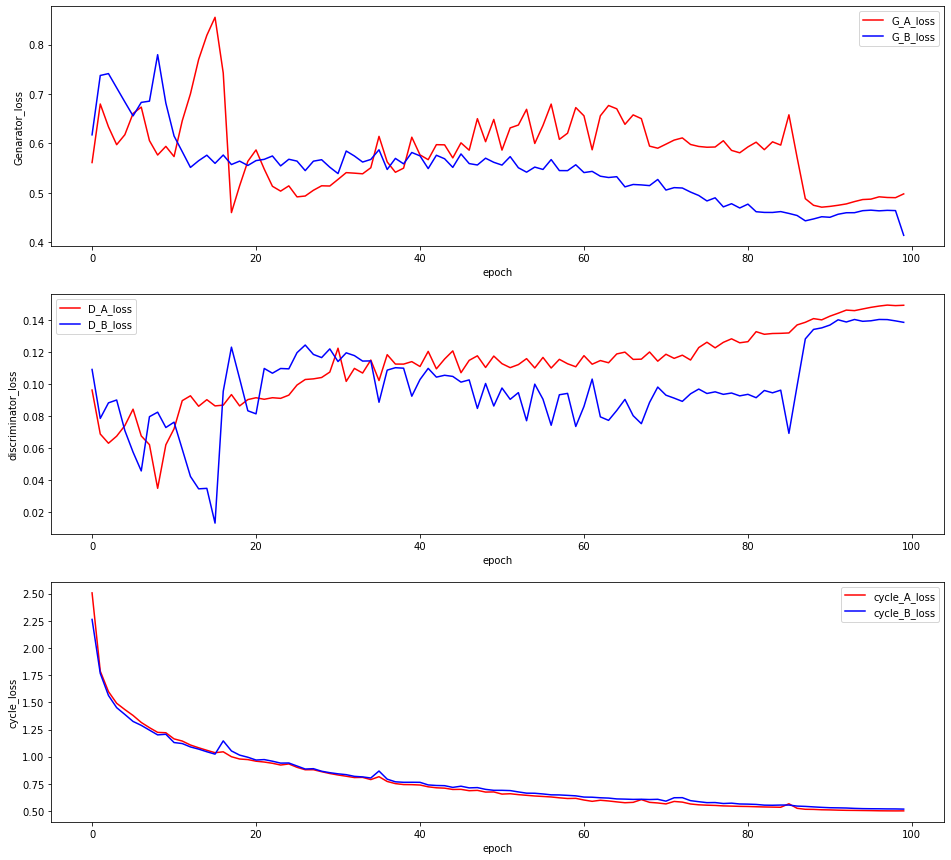

In [25]:
from cProfile import label


epoch=np.linspace(0,99,num=100,dtype=np.int16)
fig=plt.figure(figsize=(16,15))
plt.subplot(3, 1, 1)                # nrows=2, ncols=1, index=1
plt.plot(epoch, G_A_avg_losses,'r',label='G_A_loss')
plt.plot(epoch, G_B_avg_losses,'b',label='G_B_loss')
plt.ylabel('Genarator_loss')
plt.xlabel('epoch')
plt.legend()
plt.subplot(3, 1, 2)                # nrows=2, ncols=1, index=1
plt.plot(epoch, D_A_avg_losses,'r',label='D_A_loss')
plt.plot(epoch, D_B_avg_losses,'b',label='D_B_loss')
plt.ylabel('discriminator_loss')
plt.xlabel('epoch')
plt.legend()
plt.subplot(3, 1, 3)                # nrows=2, ncols=1, index=1
plt.plot(epoch, cycle_A_avg_losses,'r',label='cycle_A_loss')
plt.plot(epoch, cycle_B_avg_losses,'b',label='cycle_B_loss')
plt.ylabel('cycle_loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

TestModel

In [ ]:
test_data_A = train_data_A
test_data_loader_A = torch.utils.data.DataLoader(dataset=test_data_A, batch_size=params['batch_size'], shuffle=False)
test_data_B = train_data_B
test_data_loader_B = torch.utils.data.DataLoader(dataset=test_data_B, batch_size=params['batch_size'], shuffle=False)

In [ ]:
count = 0
for i, (real_A, real_B) in enumerate(zip(train_data_loader_A, train_data_loader_B)):
    if(count<50):
        real_A = real_A.to(device)
        real_B = real_B.to(device)

        fake_B = G_A(real_A)
        test_recon_A = G_B(fake_B)

        fake_A = G_B(real_B)
        test_recon_B = G_A(fake_A)

        plot_train_result([real_A, real_B], [fake_B, fake_A], [test_recon_A, test_recon_B],count, save = True)
        count = count+1
    else:
        break